# Bias on Wikipedia

## Todd Schultz
Due: November 2, 2017

For this assignment, your job is to analyze what the nature of political articles on Wikipedia - both their existence, and their quality - can tell us about bias in Wikipedia's content.

# Imports

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
import copy

%matplotlib notebook

# Import data of politicians by country

Import the data of policitcians by country provided by Oliver Keyes and found at https://figshare.com/articles/Untitled_Item/5513449.

In [2]:
politicianFile = 'PolbyCountry_data.csv'
politicianNames = pd.read_csv(politicianFile)

# rename variables
politicianNames.rename(columns = {'page':'article_name'}, inplace = True)
politicianNames.rename(columns = {'last_edit':'revision_id'}, inplace = True)
politicianNames[0:4]

,country,article_name,revision_id
0,Abkhazia,Zurab Achba,802551672
1,Abkhazia,Garri Aiba,774499188
2,Abkhazia,Zaur Avidzba,803841397
3,Abkhazia,Raul Eshba,789818648


In [3]:
politicianNames.shape

(47997, 3)

# Import population by country

Import the population by country provided PRB and found at http://www.prb.org/DataFinder/Topic/Rankings.aspx?ind=14. The data is from mid-2015.

In [4]:
countryFile = 'Population Mid-2015.csv'
tempDF = pd.read_csv(countryFile, header=1)

# change population to a numeric value
a = np.zeros(tempDF.shape[0])
for idata in range(0,tempDF.shape[0]):
    b = tempDF['Data'][idata]
    a[idata] = float(b.replace(',', ''))

#countryPop = pd.DataFrame(data={'country': tempDF['Location'], 'population': tempDF['Data']})
countryPop = pd.DataFrame(data={'country': tempDF['Location'], 'population': a})

countryPop[0:5]

,country,population
0,Afghanistan,32247000.0
1,Albania,2892000.0
2,Algeria,39948000.0
3,Andorra,78000.0
4,Angola,25000000.0


# Combined data
Combine the data frames into a single data frame with the following variables. 
Column, country, article_name, revision_id, article_quality, population
Make a placeholder, empty variable for article_quality to be filled in next. 

In [5]:
# First add placeholder to politicianNames dataframe for article quality
politicianNames = politicianNames.assign(article_quality = "")

# Next, join politicianNames with countryPop
politicData = politicianNames.merge(countryPop,how = 'inner')

#politicianNames[0:5]
politicData[0:5]

,country,article_name,revision_id,article_quality,population
0,Afghanistan,Laghman Province,778690357,,32247000.0
1,Afghanistan,Roqia Abubakr,779839643,,32247000.0
2,Afghanistan,Sitara Achakzai,803055503,,32247000.0
3,Afghanistan,Khadija Ahrari,805920528,,32247000.0
4,Afghanistan,Rahila Bibi Kobra Alamshahi,717743144,,32247000.0


In [6]:
politicData.shape

(46348, 5)

# ORES article quality data
Wikimedia API endpoint for a machine learning system called ORES ("Objective Revision Evaluation Service") found at https://www.mediawiki.org/wiki/ORES and documentaiton found at https://ores.wikimedia.org/v3/#!/scoring/get_v3_scores_context_revid_model. ORES estimates the quality of an article (at a particular point in time), and assigns a series of probabilities that the article is in one of 6 quality categories. The options are, from best to worst:

* FA - Featured article
* GA - Good article
* B - B-class article
* C - C-class article
* Start - Start-class article
* Stub - Stub-class article


In [7]:
# ORES
endpoint = 'https://ores.wikimedia.org/v3/scores/{project}/{revid}/{model}'
headers = {'User-Agent' : 'https://github.com/your_github_username', 'From' : 'your_uw_email@uw.edu'}

for irevid in range(0, politicData.shape[0]):
    revidstr = str(politicData['revision_id'][irevid])
    #print(revidstr)
    params = {'project' : 'enwiki',
              'model' : 'wp10',
              'revid' : revidstr
              }
    
    api_call = requests.get(endpoint.format(**params))
    response = api_call.json()
    #print(json.dumps(response, indent=4, sort_keys=True))
    
    # Create data frame and add numeric values for the plotting variable
    politicData.loc[irevid,'article_quality'] = response['enwiki']['scores'][revidstr]['wp10']['score']['prediction']

# Write out csv file
politicData.to_csv('en-wikipedia_bias_2015a.csv', index=False)
politicData[0:4]

,country,article_name,revision_id,article_quality,population
0,Afghanistan,Laghman Province,778690357,Start,32247000.0
1,Afghanistan,Roqia Abubakr,779839643,Stub,32247000.0
2,Afghanistan,Sitara Achakzai,803055503,GA,32247000.0
3,Afghanistan,Khadija Ahrari,805920528,GA,32247000.0


In [8]:
# Read in csv file if needed
#politicData = pd.read_csv('en-wikipedia_bias_2015a.csv')
#politicData[0:4]

# Analysis
Your analysis will consist of calculating the proportion (as a percentage) of articles-per-population and high-quality articles for each country. By "high quality" articles, in this case we mean the number of articles about politicians in a given country that ORES predicted would be in either the "FA" (featured article) or "GA" (good article) classes.

Examples:

* if a country has a population of 10,000 people, and you found 10 articles about politicians from that country, then the percentage of articles-per-population would be .1%.
* if a country has 10 articles about politicians, and 2 of them are FA or GA class articles, then the percentage of high-quality articles would be 20%.

## Visualizations
Produce four visualizations that show:

* 10 highest-ranked countries in terms of number of politician articles as a proportion of country population
* 10 lowest-ranked countries in terms of number of politician articles as a proportion of country population
* 10 highest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country
* 10 lowest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country

In [39]:
# Create dataframe variables
uniquecountries = copy.deepcopy(politicData.country.unique())
countryData = pd.DataFrame(data={'country': uniquecountries})
countryData = countryData.assign(**{'article_per_pop_percent': np.zeros(uniquecountries.shape[0])})
countryData = countryData.assign(**{'highqual_art_percent': np.zeros(uniquecountries.shape[0])})
countryData = copy.deepcopy(countryData)

print(countryData.shape)
countryData[0:4]

(185, 3)


,country,article_per_pop_percent,highqual_art_percent
0,Afghanistan,0.0,0.0
1,Albania,0.0,0.0
2,Algeria,0.0,0.0
3,United States,0.0,0.0


In [40]:
politicData['article_quality'][0:4]

0    Start
1     Stub
2       GA
3       GA
Name: article_quality, dtype: object

In [44]:
# disable warning about sliced variable assignment, found on stackoverflow.com
pd.options.mode.chained_assignment = None  # default='warn'

# Compute articles-per-population for each country, and percent high-quality articles for each country
for icountry in range(0,countryData.shape[0]):
    loopcountry = countryData['country'][icountry]
    looppop = countryPop['population'][countryPop['country'] == loopcountry]
    
    # find articles for politicians from loopcountry
    Idxarts = politicData['country'] == loopcountry
    looparticles = copy.copy(politicData['article_quality'][Idxarts])
    IdxGA = looparticles == 'GA'
    IdxFA = looparticles == 'FA'
    nHQarts = sum(IdxGA) + sum(IdxFA)
    
    #countryData.loc[icountry,'article_per_pop_percent'] = 100*sum(Idxarts)/looppop
    #countryData.loc[icountry,'highqual_art_percent'] = 100*nHQarts/sum(Idxarts)
    countryData['article_per_pop_percent'][icountry] = 100*sum(Idxarts)/looppop
    countryData['highqual_art_percent'][icountry] = 100*nHQarts/sum(Idxarts)
    

countryData[0:4]

,country,article_per_pop_percent,highqual_art_percent
0,Afghanistan,0.001014,5.504587
1,Albania,0.015906,1.086957
2,Algeria,0.000298,2.521008
3,United States,0.000341,8.021878


In [112]:
# Create graphs

# sort countryData by article_per_pop_percent
cdsorted = countryData.sort_values(by='article_per_pop_percent', ascending=0)
cdsorted[0:4]

,country,article_per_pop_percent,highqual_art_percent
174,Tuvalu,0.466102,0.0
123,Nauru,0.451197,0.0
143,San Marino,0.263636,0.0
117,Monaco,0.112896,0.0


<IPython.core.display.Javascript object>


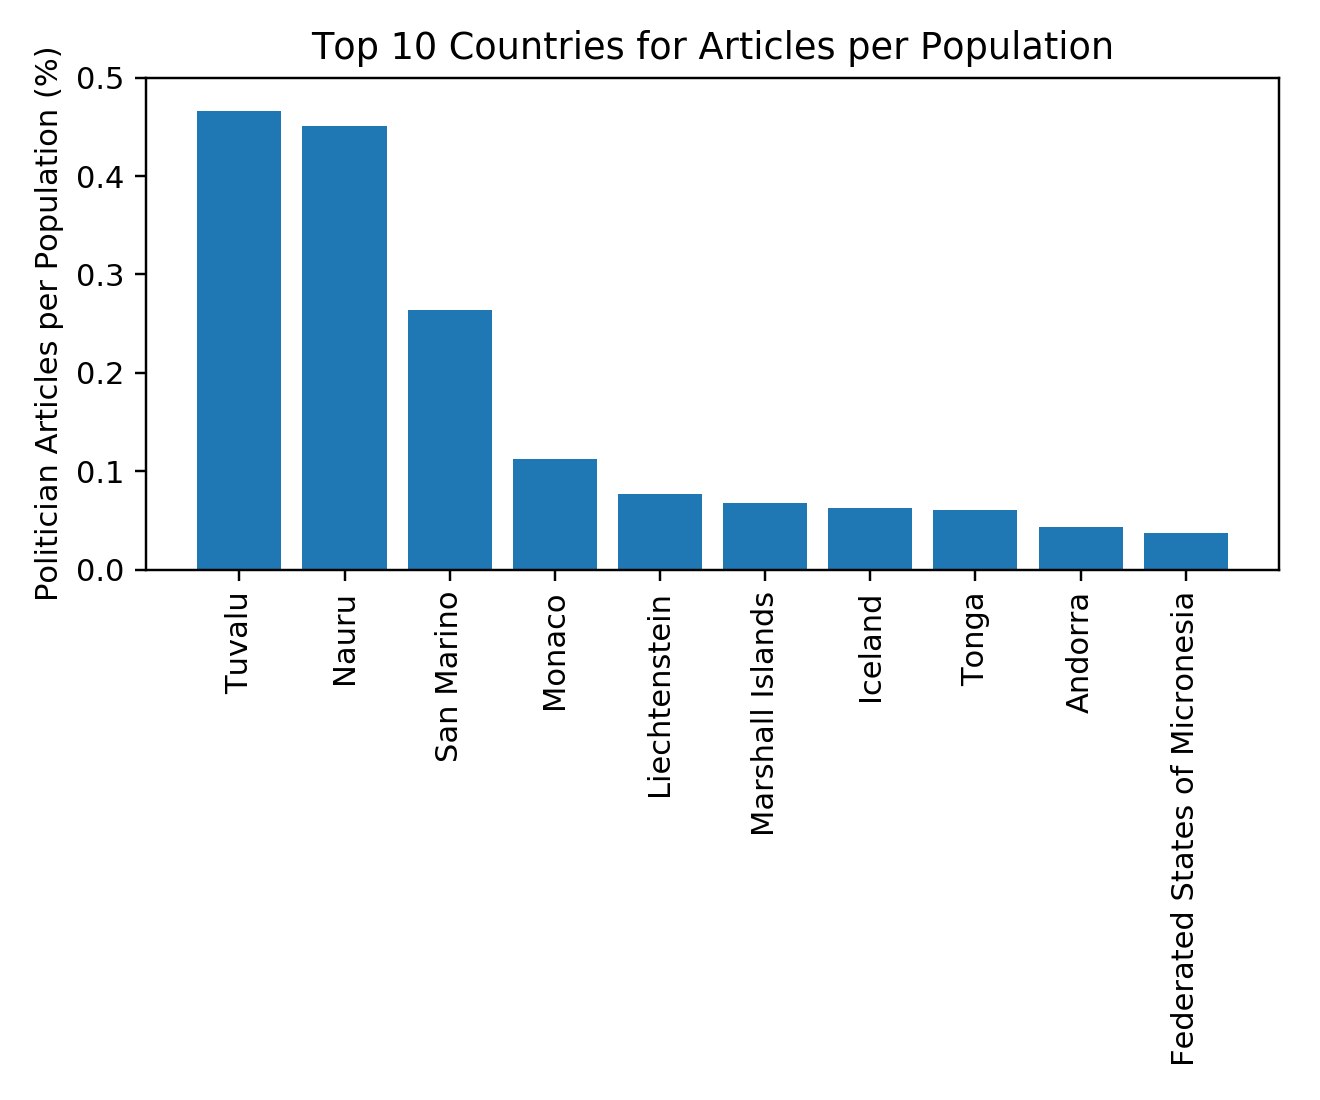

In [113]:
# 10 highest-ranked countries in terms of number of politician articles as a proportion of country population
plt.figure(figsize=(6,5))
plt.bar(range(0,10), cdsorted['article_per_pop_percent'][0:10])
plt.title('Top 10 Countries for Articles per Population')
plt.ylabel('Politician Articles per Population (%)')
plt.xticks(range(0,10), cdsorted['country'][0:10], rotation=90)
plt.ylim((0,0.5))
plt.tight_layout()
plt.savefig('Top10ArticlesperPopulation.jpg')

<IPython.core.display.Javascript object>


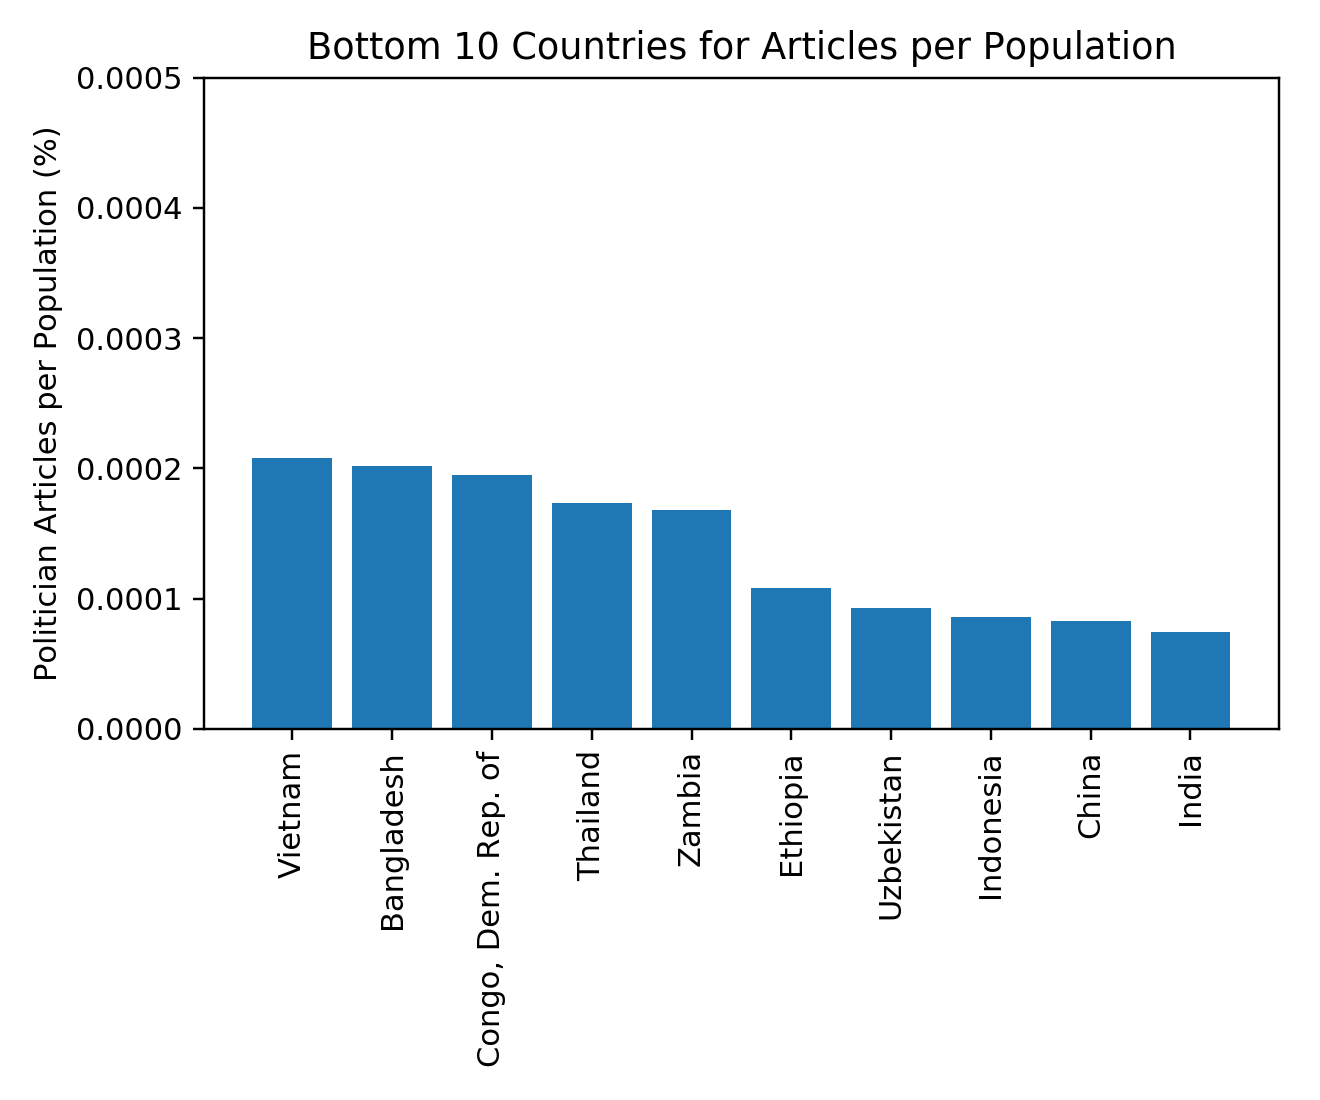

In [114]:
# 10 lowest-ranked countries in terms of number of politician articles as a proportion of country population
plt.figure(figsize=(6,5))
plt.bar(range(0,10), cdsorted['article_per_pop_percent'][-10:])
plt.title('Bottom 10 Countries for Articles per Population')
plt.ylabel('Politician Articles per Population (%)')
plt.xticks(range(0,10), cdsorted['country'][-10:], rotation=90)
plt.ylim((0,0.0005))
plt.tight_layout()
plt.savefig('Botom10ArticlesperPopulation.jpg')

In [115]:
# sort countryData by article_per_pop_percent
cdsorted = countryData.sort_values(by='highqual_art_percent', ascending=0)
cdsorted[0:4]

,country,article_per_pop_percent,highqual_art_percent
34,Central African Republic,0.001225,11.764706
140,Romania,0.002228,10.633484
179,Vanuatu,0.022342,9.677419
21,Guinea-Bissau,0.001174,9.523810


<IPython.core.display.Javascript object>


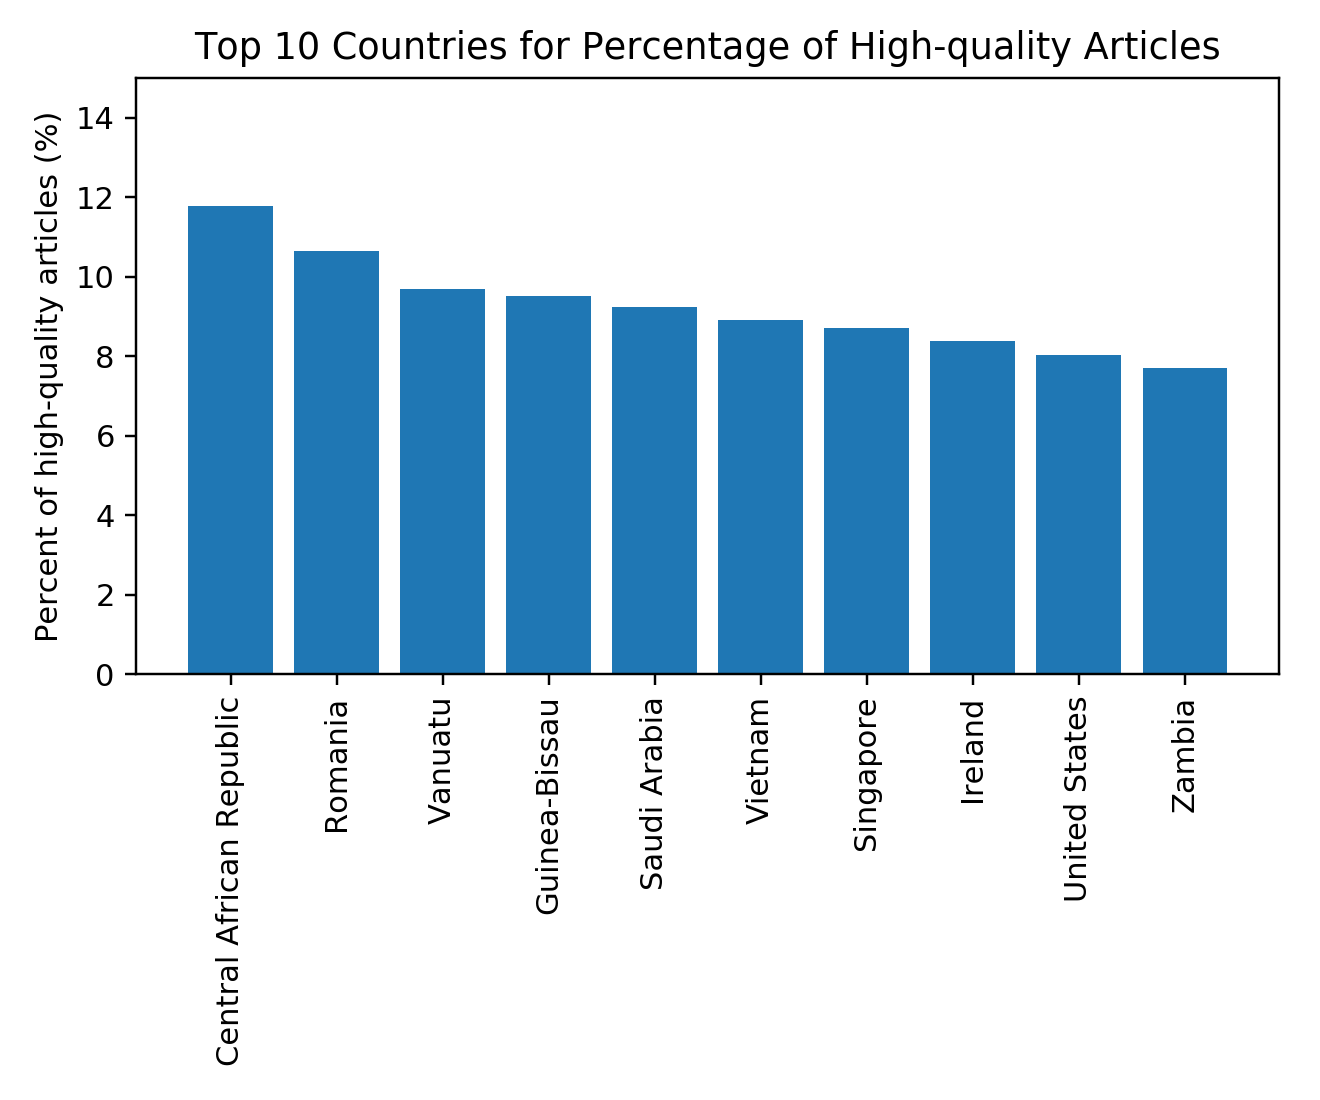

In [116]:
# 10 highest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country
plt.figure(figsize=(6,5))
plt.bar(range(0,10), cdsorted['highqual_art_percent'][0:10])
plt.title('Top 10 Countries for Percentage of High-quality Articles')
plt.ylabel('Percent of high-quality articles (%)')
plt.xticks(range(0,10), cdsorted['country'][0:10], rotation=90)
plt.ylim((0,15))
plt.tight_layout()
plt.savefig('Top10HQArticlespercent.jpg')

<IPython.core.display.Javascript object>


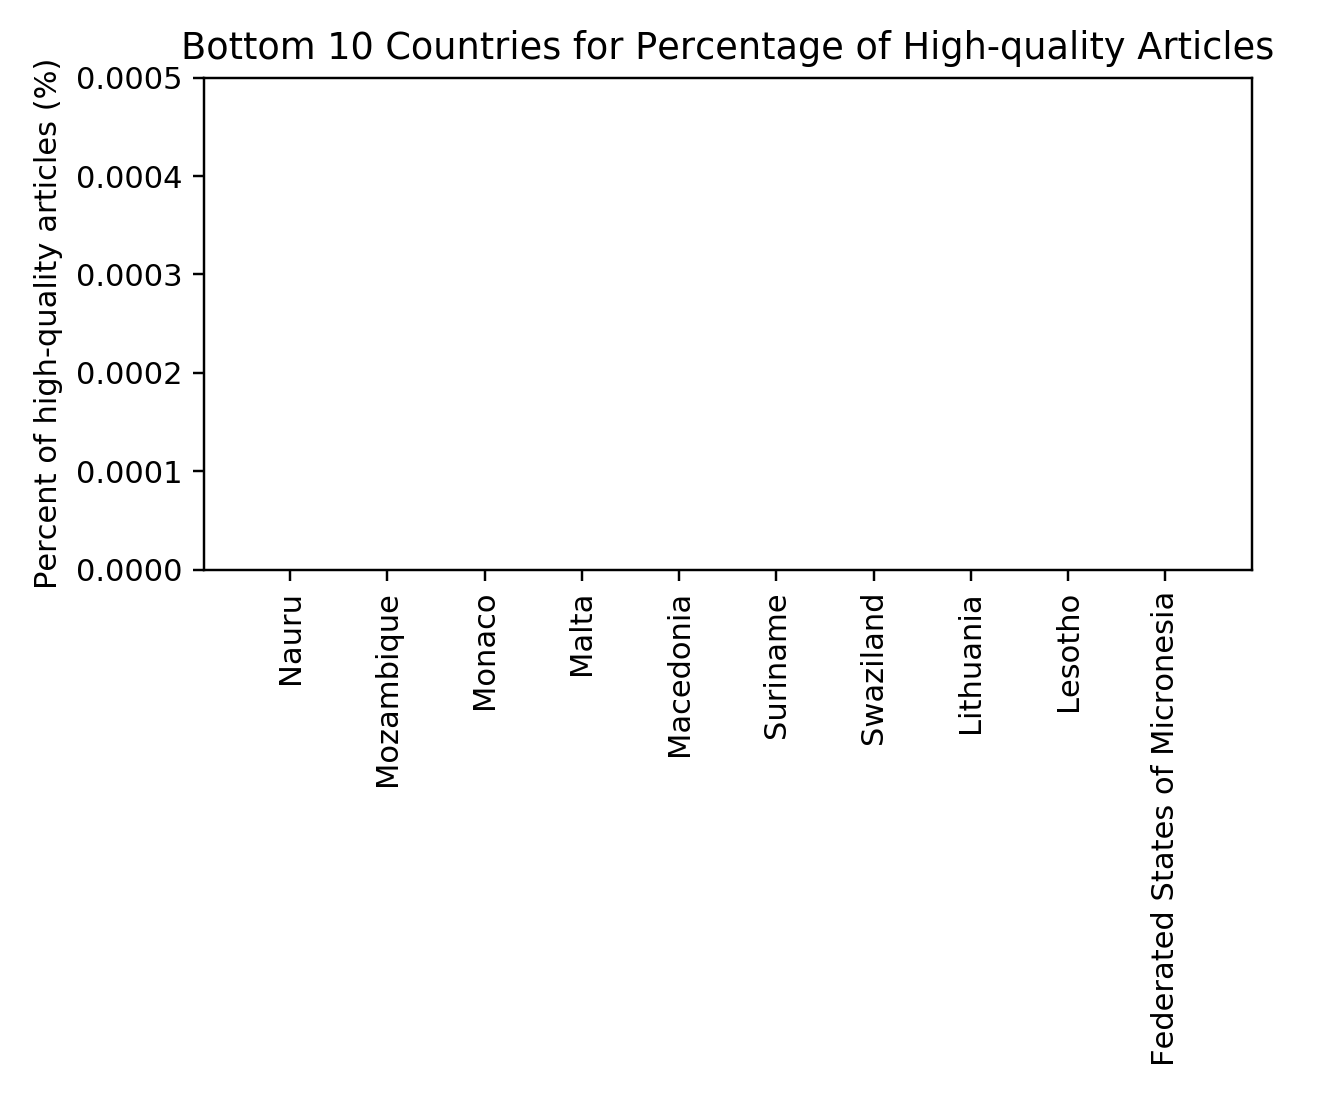

In [117]:
# 10 lowest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country
plt.figure(figsize=(6,5))
plt.bar(range(0,10), cdsorted['highqual_art_percent'][-10:])
plt.title('Bottom 10 Countries for Percentage of High-quality Articles')
plt.ylabel('Percent of high-quality articles (%)')
plt.xticks(range(0,10), cdsorted['country'][-10:], rotation=90)
plt.ylim((0,0.0005))
plt.tight_layout()
plt.savefig('Botom10HQArticlespercent.jpg')

In [108]:
# Investigate bottom 10 for percentage of high-quality articles
cdsorted['highqual_art_percent'][-10:]

# Okay, they are all zero. So, let's find all the countries that have no high-quality articles.
InoHQ = countryData['highqual_art_percent']==0
print('Total number of countries without high-quality articles: ' + str(sum(InoHQ)))
countryData['country'][InoHQ]

Total number of countries without high-quality articles: 37


4                             Andorra
6                 Antigua and Barbuda
13                            Bahrain
15                           Barbados
17                            Belgium
18                             Belize
24                           Botswana
33                         Cape Verde
48                           Djibouti
49                           Dominica
55                  Equatorial Guinea
56                            Eritrea
62                      French Guiana
69                            Grenada
73                             Guyana
87                         Kazakhstan
89                           Kiribati
91                             Kosovo
93                         Kyrgyzstan
97                            Lesotho
101                         Lithuania
103                         Macedonia
109                             Malta
115    Federated States of Micronesia
117                            Monaco
121                        Mozambique
123         

# Conclusions

The results for the top 10 countries for the number of politician articles per population shows a trend of low population countries having a higher percentage. This implies that the number of articles about policitians could have less variation than expected. The surprise in the bottom 10 countries for the number of politician articles per population was China and India. Here the large populations are working again the number of articles to create a lower percentage. I would also wonder about China due to the state enforced censorship on all media. I would consider investigating the number of articles about politician for each country and its correlation to the population. I would hypothesize that there is only a small correlation. The surprise from the percentage of high-quality articles about policitians was the inclusion of Belgium and Belize in the set of countries with no high-quality articles. Belgium is surprising because of its membership in the European Union and Belize is surprising because of its marketing as a vacation destination for forgien travelers, especially from the US and Europe. As for a bias, I'm seeing a trend that favors developed nations. I would propose that this should be expected as under-developed nations would lack the general availability of computers and internet resources to be strong, diverse constributors to Wikipedia. However, this hypotheses would still need further investigation and I would wonder about potential outliers of dictorship countries that might employ state workers to contributed on behalf of the state. 

As for my thoughts regarding this assignment. I, again, struggled with Jupyter Notebooks as they lack the development tools of a full-featured integrated development environment and lack a spell checker. I also struggled with data management and organization as I felt the data had an relational aspect to it that was nicely captured with relational tables, i.e. Pandas dataframes. However, the mechanics of working with the dataframes was frustrating as indexing was inconsistent and data type support was difficult. In one place in my work above I had to disable a warning as the only feasible option. I do take this as confirmation of the data science myth that 80% of a data scientist'a time is spend on data importing, processing, and cleaning. 